<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [69]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [70]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [71]:
full_data['unlabeled_data']

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       ...,


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

# Data augmentation and pipeline

unlabeled: (26000, 1, 32, 32)
labeled data: (2000, 1, 32, 32)
labeled labels: (2000, 5)
examples from labeled, repr1, repr2, unlabeled


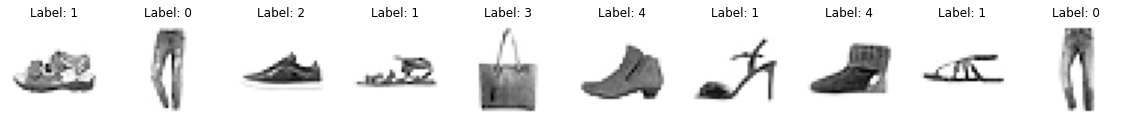

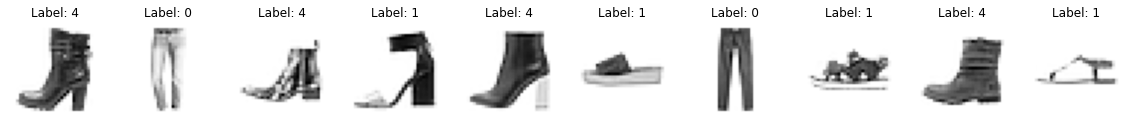

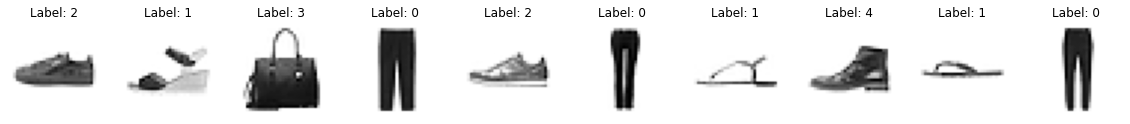

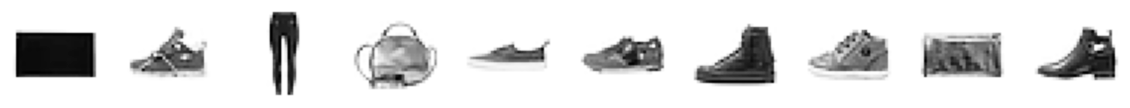

In [72]:
from torchvision.transforms.transforms import RandomRotation
# code for data augmentation pipeline 
print(f'unlabeled: {full_data["unlabeled_data"].shape}')
print(f'labeled data: {full_data["labeled_data"]["data"].shape}')
print(f'labeled labels: {full_data["labeled_data"]["labels"].shape}')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# augmentations
transform = transforms.Compose([
        transforms.ToTensor(),
])

# augmentations = []

batch_size = 10

class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0))
        return self.data[idx]


class LabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data['data'])
        self.labels = torch.tensor(data['labels'])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0)), self.labels[idx]
        return self.data[idx], self.labels[idx]


def show_images(x, y=None, ncols=batch_size):
    """ plots first ncols images in a batch """
    x = x.view(ncols, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        if y is not None:
            ax[idx].set_title(f'Label: {torch.nonzero(y[idx]).item()}')
    plt.show()

labeled_ds = LabeledDataset(full_data['labeled_data'], transform=transform)
repr_ds1 = LabeledDataset(full_data['representative_set_1'], transform=transform)
repr_ds2 = LabeledDataset(full_data['representative_set_2'], transform=transform)
unlabeled_ds = UnlabeledDataset(full_data['unlabeled_data'], transform=transform)

print('examples from labeled, repr1, repr2, unlabeled')
for dl in [DataLoader(ds, batch_size=batch_size, shuffle=True)
           for ds in [labeled_ds, repr_ds1, repr_ds2]]:
    for (x, y) in dl:
        show_images(x, y)
        break
for (x) in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    show_images(x)
    break

# Model definitions

In [73]:
# code for model definitions goes here
# model goals:
# 1. detect out of distribution data
# 2. give low (10) dimensional description of dataset in terms of the 5 modes
# 3. classify remaining data points into the 5 classes

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma)
        z = mu + sigma * epsilon
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr


class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, n_classes),nn.Softmax(dim=1))
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        out = self.fc_output(h)
        return out


class VAE(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
            
    def forward(self, x):
        x = x.view(x.shape[0], encoder.input_dim)
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        y = self.classifier(z)
        # From mu and log_sigma, find if it's out of bounds, and the index of it.
        
        # Overwrite y

        return x_reconstr, mu, log_sigma, y

# Training and validation loop

In [74]:
# write your training and validation loop here

input_dim = 32*32
hidden_dim = 50
latent_dim = 10
n_classes = 5

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
classifier = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim, n_classes=n_classes)

vae = VAE(encoder=encoder, decoder=decoder, classifier=classifier)

In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Encoder Model has {count_parameters(encoder)} parameters')
print(f'Decoder Model has {count_parameters(decoder)} parameters')
print(f'Classifier Model has {count_parameters(classifier)} parameters')
print(f'VAE Model has {count_parameters(vae)} parameters')

Encoder Model has 54820 parameters
Decoder Model has 55324 parameters
Classifier Model has 3355 parameters
VAE Model has 113499 parameters


In [76]:
def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: add classification loss here (cross entropy)
        # TODO: should this also add some kind of divergence to push different classes away?????
        # criterion = nn.functional.cross_entropy()
        classify_loss = nn.functional.cross_entropy(y_pred,y)

    total_loss = reconstr_loss + kl_loss + classify_loss

    return total_loss, reconstr_loss, kl_loss, classify_loss

In [77]:
# Then, train on the labeled data
# perform training

# train on the labeled data
epochs = 10

import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

lr = 1e-4

def fit_unlabeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': []}
    

    for epoch in tqdm(range(epochs)):
        model.train()
        # optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        n_datapoints = 0
        for x in dl:
            optimizer.zero_grad()

            # y is unused for unlabeled data
            x_reconstr, mu, log_sigma, _ = model(x)
            loss, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)

    print("Training complete!")
    return loss_graph

dl_dl = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True)
graph = fit_unlabeled(vae, dl_dl)

Start training VAE...


100%|██████████| 10/10 [00:38<00:00,  3.86s/it]

Training complete!


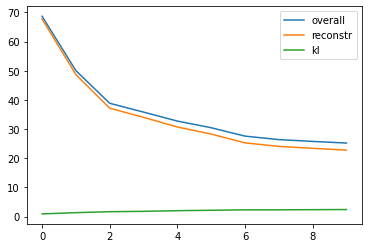

In [78]:
for label in ['overall', 'reconstr', 'kl']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()


torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


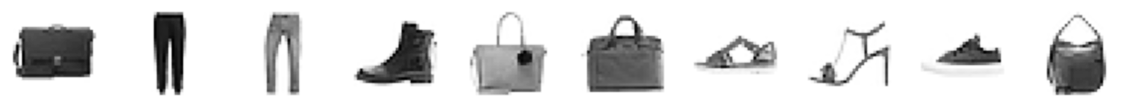

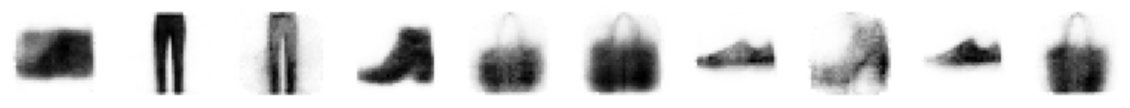

In [79]:
# Show some examples of vae-encoded images
for x in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        show_images(x)
        show_images(x_reconstr)
        break

In [80]:
# perform training

# Then, train on the labeled data
epochs = 10

import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional

lr = 5e-3

def fit_labeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.9)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        overall_classify_loss = 0
        n_datapoints = 0
        for (x,y) in dl:
            optimizer.zero_grad()

            x_reconstr, mu, log_sigma, y_pred = model(x)

            loss, reconstr_loss, kl_loss, classify_loss = loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)
        loss_graph['classify'].append(overall_classify_loss / n_datapoints)

    print("Training complete!")
    return loss_graph

graph = fit_labeled(vae, DataLoader(labeled_ds, batch_size=batch_size, shuffle=True))

Start training VAE...


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

Training complete!


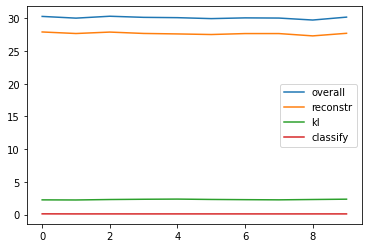

In [81]:
for label in ['overall', 'reconstr', 'kl', 'classify']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()

torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


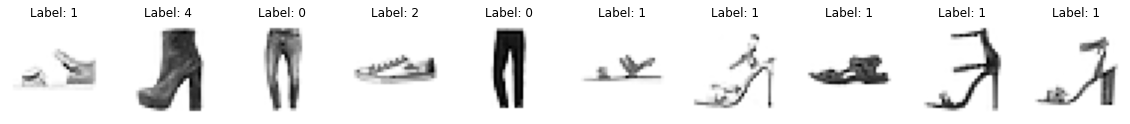

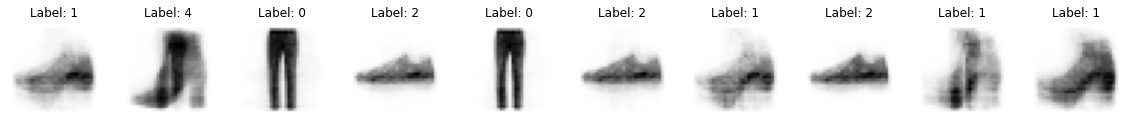

In [82]:
# Show examples of vae-encoded labeled images
for x, y in DataLoader(labeled_ds, batch_size=batch_size, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, y_pred = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        # one-hot encode y_pred
        max_yp = y_pred.argmax(1)
        y_pred = torch.zeros(y_pred.shape).scatter(1, max_yp.unsqueeze(1), 1.0)
        show_images(x, y=y)
        show_images(x_reconstr, y=y_pred)
        break

torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


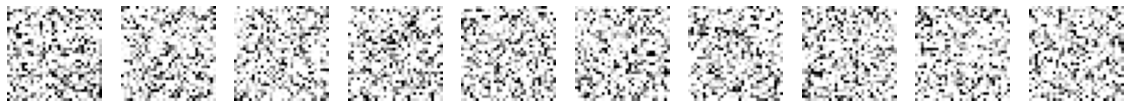

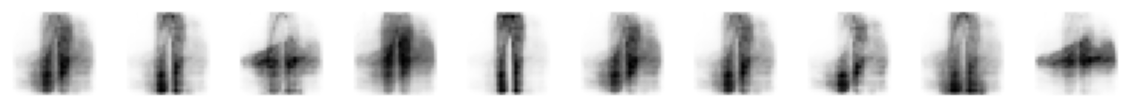

In [98]:
# What if we ask it to encode random images?
class RandomDataset(Dataset):
    def __init__(self, len, transform=None):
        self.transform = transform
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Create a random 32x32 image, the std. dev and mean were manually guestimated from some unlabeled images
        data = torch.clamp(torch.randn((1, 32, 32)) * 150 + 26, min=0, max=255).to(torch.uint8).numpy()
        if self.transform:
            return self.transform(data).permute((1, 2, 0))
        return data

random_ds = RandomDataset(len(repr_ds1), transform=transform)

for x in DataLoader(random_ds, batch_size=batch_size, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        show_images(x)
        show_images(x_reconstr)
        break

# Inspection, Validation, and Analysis

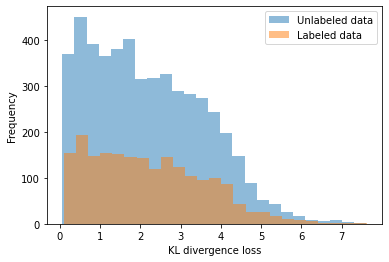

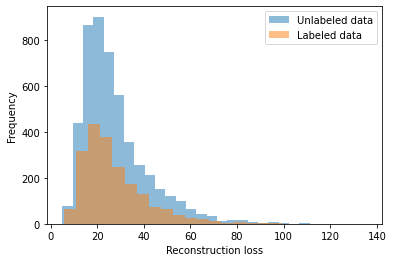

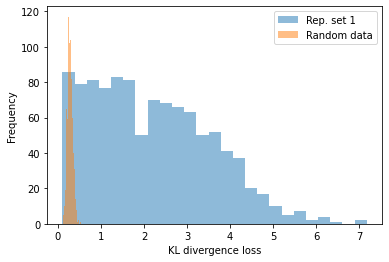

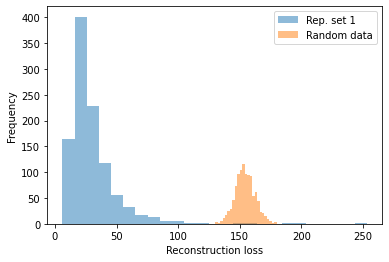

In [99]:
# Inspect, validate, and analyse your trained model
# 1. histogram of kl divergence values on the training sets
# 2. kl divergence on a random image

def loss_histogram(ds, model, lim=5000, kl_or_reconstr='kl'):
    '''
    Show a histogram of kl divergence loss component for all values of dl
    '''
    loss_values = []
    for x in DataLoader(ds, batch_size=1, shuffle=True):
        if len(x) == 2:
            # in case it comes with labels, remove the labels
            x = x[0]
        with torch.no_grad():
            x_reconstr, mu, log_sigma, _ = model(x)
            _, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
            loss_values.append(kl_loss if kl_or_reconstr=='kl' else reconstr_loss)
            if len(loss_values) >= lim:
                break
    
    plt.hist(loss_values, bins=25, alpha=0.5, label=label)
    plt.xlabel('KL divergence loss' if kl_or_reconstr=='kl' else 'Reconstruction loss')
    plt.ylabel('Frequency')

loss_histogram(unlabeled_ds, vae)
loss_histogram(labeled_ds, vae)
plt.legend(['Unlabeled data', 'Labeled data'])

plt.figure()
loss_histogram(unlabeled_ds, vae, kl_or_reconstr='reconstr')
loss_histogram(labeled_ds, vae, kl_or_reconstr='reconstr')
plt.legend(['Unlabeled data', 'Labeled data'])

plt.figure()
loss_histogram(repr_ds1, vae)
loss_histogram(random_ds, vae)
plt.legend(['Rep. set 1', 'Random data'])

plt.figure()
loss_histogram(repr_ds1, vae, kl_or_reconstr='reconstr')
loss_histogram(random_ds, vae, kl_or_reconstr='reconstr')
plt.legend(['Rep. set 1', 'Random data'])

In [216]:
# perform testing
mu1, mu2, mu3, mu4, mu5, mu_out = list(), list(), list(), list(), list(), list()
s1, s2, s3, s4, s5, s_out = list(), list(), list(), list(), list(), list()

def test_loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')

    kl_loss = torch.zeros((10, 1))
    for inx, _ in enumerate(kl_loss):
        kl_loss[inx] = 0.5 * torch.sum(mu[inx].pow(2) + (2*log_sigma[inx]).exp() - 2*log_sigma[inx] - 1)
        
    pad_zero = torch.zeros((10, 1))
    y_pred = torch.hstack((y_pred, pad_zero))
    
    for inx, kl_row in enumerate(kl_loss):
        # TODO: clearly this is wrong as shit
        # threshold on the reconstruction loss, not kl loss
        # https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/06/ANOMALY-DETECTION-FOR-TIME-SERIES-USING-VAE-LSTM-HYBRID-MODEL.pdf
        if kl_row < 1*0.1 or kl_row > 1*1.9:
            y_pred[inx] = torch.Tensor([0, 0, 0, 0, 0, 1])
            
    if y is not None and y_pred is not None:
        # TODO: should this also add some kind of divergence to push different classes away?????

        classify_loss = nn.functional.cross_entropy(y_pred,y)
        # classify_loss = torch.sum(-y * torch.log(y_pred) - (1 - y) * torch.log(1 - y_pred))
    
    total_loss = reconstr_loss + sum(kl_loss)[0] + classify_loss
    
    return total_loss, reconstr_loss, sum(kl_loss)[0], classify_loss

def test_labeled(model, dl):
    print("Start testing VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    
    model.eval()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    overall_classify_loss = 0
    n_datapoints = 0
    with torch.no_grad():
        for (x,y) in dl:
            if x.shape[0] != 10:
                continue
            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            for i in range(batch_size):
                if y[i][0] == 1:
                    mu1.append(mu[i][0])
                    s1.append(log_sigma[i][0])
                elif y[i][1] == 1:
                    mu2.append(mu[i][0])
                    s2.append(log_sigma[i][0])
                elif y[i][2] == 1:
                    mu3.append(mu[i][0])
                    s3.append(log_sigma[i][0])
                elif y[i][3] == 1:
                    mu4.append(mu[i][0])
                    s4.append(log_sigma[i][0])
                elif y[i][4] == 1:
                    mu5.append(mu[i][0])
                    s5.append(log_sigma[i][0])
                elif y[i][5] == 1:
                    mu_out.append(mu[i][0])
                    s_out.append(log_sigma[i][0])

            loss, reconstr_loss, kl_loss, classify_loss = test_loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)

            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()

            n_datapoints += batch_size
    
    loss_graph['overall'].append(overall_loss / n_datapoints)
    loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
    loss_graph['kl'].append(overall_kl_loss / n_datapoints)
    loss_graph['classify'].append(overall_classify_loss / n_datapoints)
    print(f"\n overall:{overall_loss / n_datapoints}\n reconstr:{overall_reconstr_loss / n_datapoints}\n kl:{overall_kl_loss / n_datapoints}\n classify:{overall_classify_loss / n_datapoints}")

    return loss_graph

graph = test_labeled(vae, DataLoader(repr_ds1, batch_size=batch_size, shuffle=True))

Start testing VAE...

 overall:8.69074814206078
 reconstr:8.016953491937546
 kl:0.5108774901571728
 classify:0.16291716711861748


In [219]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu_mu1 = np.mean(mu1)
mu_mu2 = np.mean(mu2)
mu_mu3 = np.mean(mu3)
mu_mu4 = np.mean(mu4)
mu_mu5 = np.mean(mu5)
mu_mu_out = np.mean(mu_out)

s_s1 = np.sqrt(sum([x**2 for x in s1])/len(s1))
s_s2 = np.sqrt(sum([x**2 for x in s2])/len(s2))
s_s3 = np.sqrt(sum([x**2 for x in s3])/len(s3))
s_s4 = np.sqrt(sum([x**2 for x in s4])/len(s4))
s_s5 = np.sqrt(sum([x**2 for x in s5])/len(s5))
s_s_out = np.sqrt(sum([x**2 for x in s_out])/len(s_out))

mu = np.mean([mu_mu1, mu_mu2, mu_mu3, mu_mu4, mu_mu5, mu_mu_out])
sigma = np.sqrt(sum([s_s1**2, s_s2**2, s_s3**2, s_s4**2, s_s5**2, s_s_out**2]))

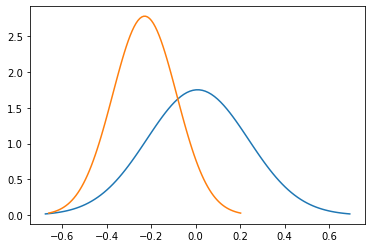

In [239]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_1 = np.linspace(mu_mu1 - 3*s_s1, mu_mu1 + 3*s_s1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_1, stats.norm.pdf(x_1, mu_mu1, s_s1))
plt.show()

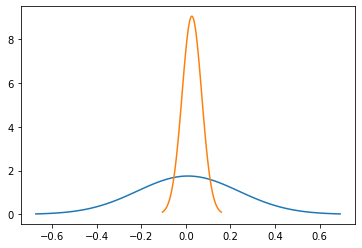

In [231]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_2 = np.linspace(mu_mu2 - 3*s_s2, mu_mu2 + 3*s_s2, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_2, stats.norm.pdf(x_2, mu_mu2, s_s2))
plt.show()

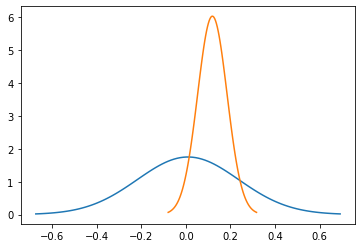

In [232]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_3 = np.linspace(mu_mu3 - 3*s_s3, mu_mu3 + 3*s_s3, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_3, stats.norm.pdf(x_3, mu_mu3, s_s3))
plt.show()

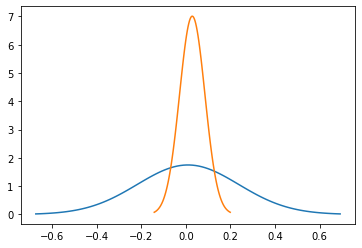

In [233]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_4 = np.linspace(mu_mu4 - 3*s_s4, mu_mu4 + 3*s_s4, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_4, stats.norm.pdf(x_4, mu_mu4, s_s4))
plt.show()

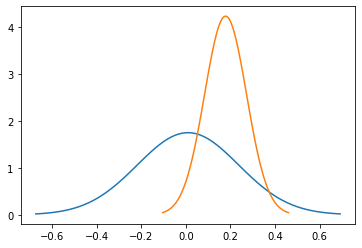

In [234]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_5 = np.linspace(mu_mu5 - 3*s_s5, mu_mu5 + 3*s_s5, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_5, stats.norm.pdf(x_5, mu_mu5, s_s5))
plt.show()

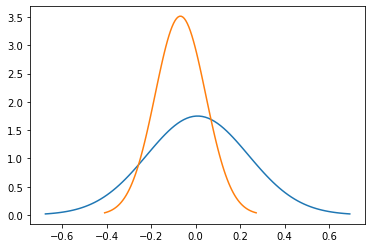

In [235]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_out = np.linspace(mu_mu_out - 3*s_s_out, mu_mu_out + 3*s_s_out, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_out, stats.norm.pdf(x_out, mu_mu_out, s_s_out))
plt.show()

In [206]:
## TODO: ROC haven't finished

def test(model, dl):
    '''
    Calculate FP, TP -> ROC.
    Return scores: (FP, TP, accuracy)
    '''
    model = model.eval()
    running_tp = 0.0
    running_fp = 0.0
    running_tn = 0.0
    running_fn = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for (x, y) in dl:
            if x.shape[0] != 10:
                continue
            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            y_pred_interpreted = torch.zeros(batch_size, 5)
            
            for inx, row in enumerate(y_pred):
                y_pred_interpreted[inx][torch.argmax(row)] = 1
            
            for r_y, r_pred in zip(y, y_pred_interpreted):
                for i_r_y, i_r_pred in zip(r_y, r_pred):
                    if i_r_pred == 1 and i_r_y == 1:
                        running_tp += 1
                    elif i_r_pred == 1 and i_r_y == 0:
                        running_fp += 1
                    elif i_r_pred == 0 and i_r_y == 0:
                        running_tn += 0
                    elif i_r_pred == 0 and i_r_y == 1:
                        running_fn += 0
            
        running_acc = (running_tp + running_tn) / (running_tn + running_fn + running_fp + running_tn)
        
        n = len(dl)
        return (running_fp / n, running_tp / n, running_acc)

def plot_roc(model, loader, thresholds, desc="Validation"):
    rocs = [test(model, loader, t) for t in thresholds]
    # Split tuples into x and y, x = FP and y = TP
    x = [roc[0] for roc in rocs]
    y = [roc[1] for roc in rocs]
    # z = accuracy, is not plotted
    z = [roc[2] for roc in rocs]
    plt.plot(x, y)
    plt.title(f"{desc} ROC")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return x, y, z


In [207]:
test(vae,DataLoader(repr_ds1, batch_size=batch_size, shuffle=True))

(5.481132075471698, 4.4245283018867925, 0.8072289156626506)